# *Monod* demonstration: identifying differenially expressed genes

We ran the *Monod* inference pipeline on four pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types. Each dataset was fit using the bursty model for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given raw counts, we can apply the $t$-test to transformed spliced count data to identify genes that are differentially expressed between cell types using the mean as a test statistic (i.e., DE-$\phi(\mu_M)$, for simplicity denoted DE-$\mu$). Further, we can iteratively it a Gaussian residual model to paired datasets' maximum likelihood physical parameter estimates. This allows us to ascribe changes in distribution shapes to the modulation of the rate of a particular biological process, i.e., patterns of DE-$b$, DE-$\beta/k$, and DE-$\gamma/k$, for simplicity denoted as DE-$\theta$.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [4]:
import time
t1 = time.time()

In [2]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [39]:
import monod
from monod import analysis
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [23]:
dataset_meta = ['B08','C01','F08','H12']
cluster_names = ['Glutamatergic','GABAergic']
dataset_names_gaba = ['allen_'+x+'_'+cluster_names[1] for x in dataset_meta] 
dataset_names_glu = ['allen_'+x+'_'+cluster_names[0] for x in dataset_meta] 
n_datasets = len(dataset_names_glu)

In [24]:
dir_string = './fits/gg_220913_024_allen_celltypes_1'

result_strings_gaba = [dir_string+'/'+x+'/Bursty_Poisson_5x6/grid_scan_results_upd.res' for x in dataset_names_gaba]
result_strings_glu = [dir_string+'/'+x+'/Bursty_Poisson_5x6/grid_scan_results_upd.res' for x in dataset_names_glu]

sd_strings_gaba = [dir_string+'/'+x+'/raw.sd' for x in dataset_names_gaba]
sd_strings_glu = [dir_string+'/'+x+'/raw.sd' for x in dataset_names_glu]

In [25]:
result_strings_glu

['./fits/gg_220913_024_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_5x6/grid_scan_results_upd.res',
 './fits/gg_220913_024_allen_celltypes_1/allen_C01_Glutamatergic/Bursty_Poisson_5x6/grid_scan_results_upd.res',
 './fits/gg_220913_024_allen_celltypes_1/allen_F08_Glutamatergic/Bursty_Poisson_5x6/grid_scan_results_upd.res',
 './fits/gg_220913_024_allen_celltypes_1/allen_H12_Glutamatergic/Bursty_Poisson_5x6/grid_scan_results_upd.res']

In [26]:
result_strings_gaba

['./fits/gg_220913_024_allen_celltypes_1/allen_B08_GABAergic/Bursty_Poisson_5x6/grid_scan_results_upd.res',
 './fits/gg_220913_024_allen_celltypes_1/allen_C01_GABAergic/Bursty_Poisson_5x6/grid_scan_results_upd.res',
 './fits/gg_220913_024_allen_celltypes_1/allen_F08_GABAergic/Bursty_Poisson_5x6/grid_scan_results_upd.res',
 './fits/gg_220913_024_allen_celltypes_1/allen_H12_GABAergic/Bursty_Poisson_5x6/grid_scan_results_upd.res']

Load in the GABAergic and glutamatergic datasets and their fits.

In [27]:
sr_arr_gaba = []
sr_arr_glu = []

sd_arr_gaba = []
sd_arr_glu = []

for j in range(n_datasets):
    sd = monod.analysis.load_search_data(sd_strings_gaba[j])
    sr = monod.analysis.load_search_results(result_strings_gaba[j])
    
    sd_arr_gaba.append(sd)
    sr_arr_gaba.append(sr)

    sd = monod.analysis.load_search_data(sd_strings_glu[j])
    sr = monod.analysis.load_search_results(result_strings_glu[j])
    
    sd_arr_glu.append(sd)
    sr_arr_glu.append(sr)


Define basic parameters. We set a fairly high $p$-value threshold.

In [28]:
n_phys_pars = sr_arr_gaba[0].sp.n_phys_pars
n_genes = sr_arr_gaba[0].n_genes
pval_thr = 0.1/n_genes
param_names = sr_arr_gaba[0].model.get_log_name_str()
gn = sr_arr_gaba[0].gene_names
fs = 12


## DE-$\mu$ testing within a replicate

First, run the $t$-test to identify potential differences between the means of transformed count distributions.

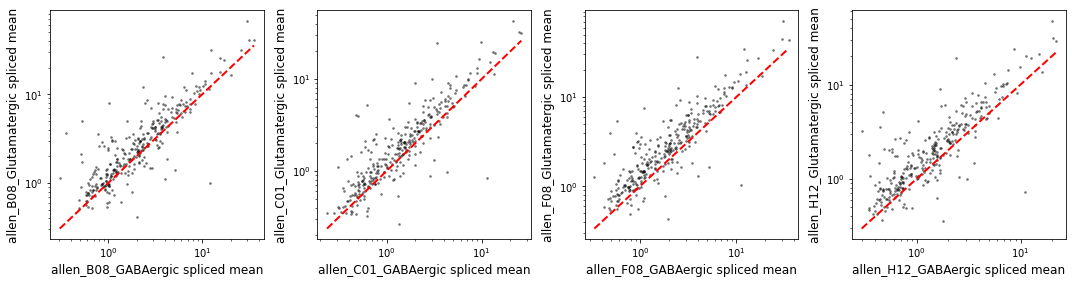

In [29]:
fig1,ax1= plt.subplots(1,n_datasets,figsize=(15,4))
for j in range(n_datasets):
    m1 = [sd_arr_gaba[j].moments[x]['S_mean']  for x in range(n_genes)]
    m2 = [sd_arr_glu[j].moments[x]['S_mean'] for x in range(n_genes)]
    ax1[j].scatter(m1,m2,3,'k',alpha=0.4)
    ax1[j].set_xscale('log')
    ax1[j].set_yscale('log')
    ax1[j].set_xlabel(dataset_names_gaba[j] +' spliced mean',fontsize=fs)
    ax1[j].set_ylabel(dataset_names_glu[j] +' spliced mean',fontsize=fs)
#     ax1[j].set_title('Spliced mean comparison')
    xl = [min(m1),max(m1)]
    ax1[j].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

fig_string = sr_arr_gaba[0].batch_analysis_string+'/mean_comparison_s.png'
plt.savefig(fig_string,dpi=450)


The differences between the means are quite small. Here, we use the size- and $\log_2$-normalized count data for the $t$-test, and show the differences between their means as the fold change.

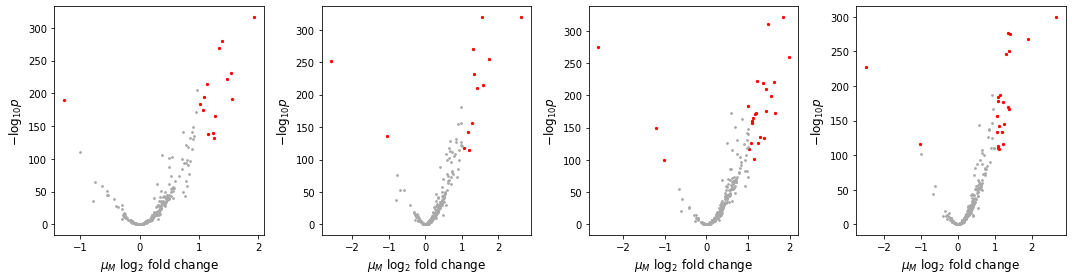

In [30]:
fig1,ax1= plt.subplots(1,n_datasets,figsize=(15,4))

de_ttest = np.zeros((n_datasets,n_genes),dtype=bool)

for j in range(n_datasets):
    gf_ttest,fc_ = monod.analysis.diffexp_mean(sd_arr_gaba[j],sd_arr_glu[j],lognormalize=True,viz=True,method='ttest',
                                   ax1=ax1[j],pval_thr=pval_thr,bonferroni=False) #note Bonferroni has already been applied
    de_ttest[j,:] = gf_ttest
    ax1[j].set_xlabel(r'$\mu_M$ $\log_2$ fold change',fontsize=fs)
    ax1[j].set_ylabel(r'$-\log_{10} p$',fontsize=fs)
fig1.tight_layout()


fig_string = sr_arr_gaba[0].batch_analysis_string+'/ttest_s.png'
plt.savefig(fig_string,dpi=450)


## DE-$\theta$ testing within a replicate

Now, we inspect the inferred parameter values $\theta$.

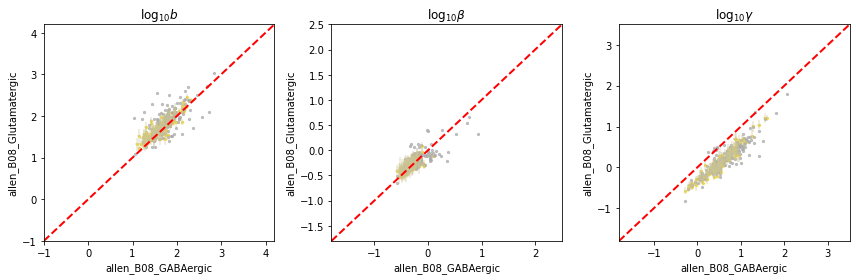

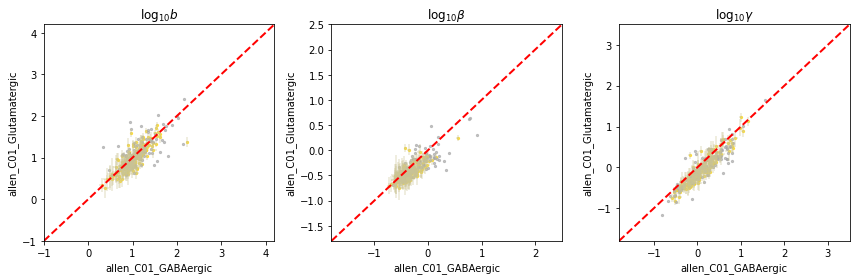

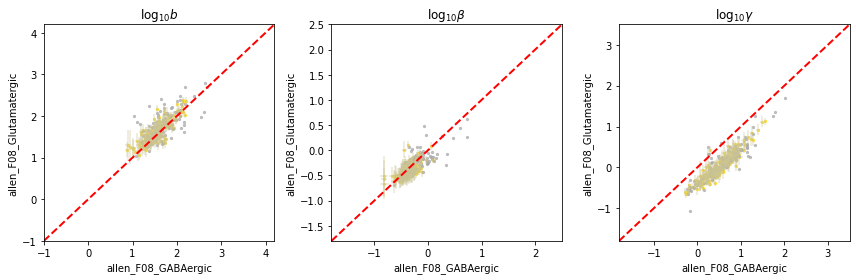

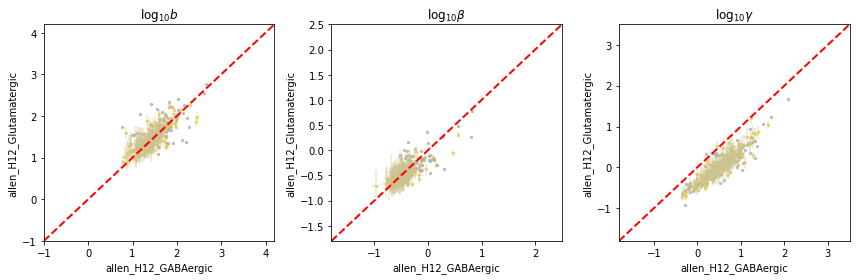

In [32]:
for j in range(n_datasets):
    monod.analysis.plot_params_for_pair(sr_arr_gaba[j],sr_arr_glu[j],\
                         distinguish_rej=True,plot_errorbars=True,meta = dataset_meta[j],xlabel = dataset_names_gaba[j],\
                         ylabel = dataset_names_glu[j])

Perform DE-$\theta$ analysis using an *ad hoc* $Z$-test procedure.

/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ggorin/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


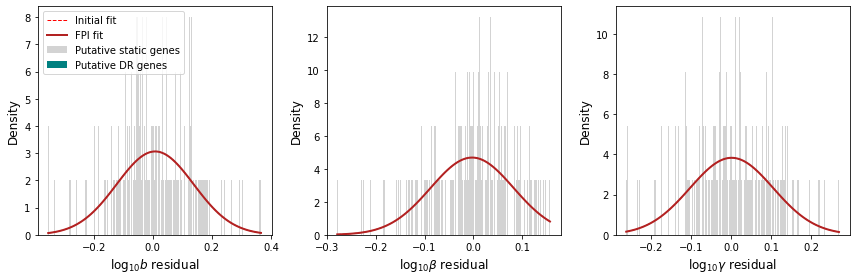

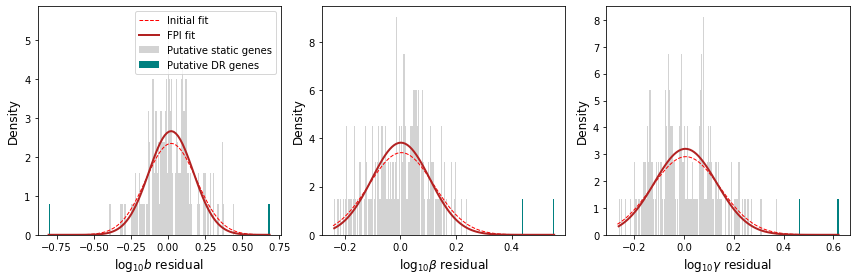

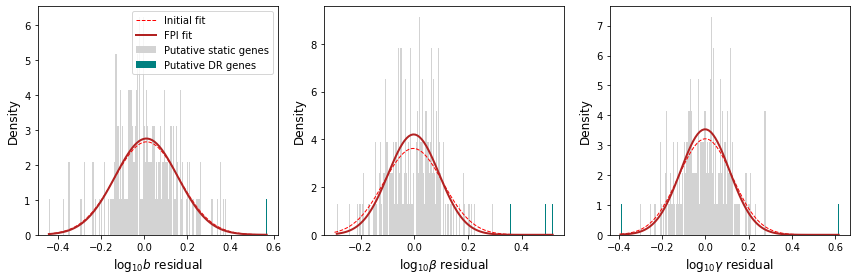

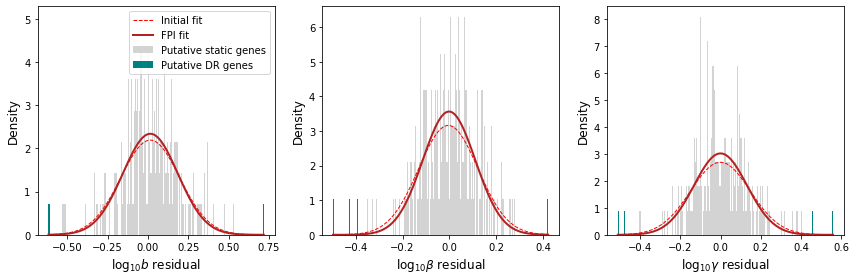

In [33]:
dr_analysis = []
for j in range(n_datasets):
    dr_analysis.append(monod.analysis.diffexp_pars(sr_arr_gaba[j],sr_arr_glu[j],viz=True,modeltype='id',
                                       meta=dataset_meta[j],use_sigma=True,pval_thr=0.001,nit=20))

In [34]:
dr_par = np.swapaxes(np.asarray([x[1] for x in dr_analysis]),1,2)
fc_par = np.swapaxes(np.asarray([x[3]/np.log10(2) for x in dr_analysis]),1,2)

Are these modulation patterns correlated? We find that the degradation and splicing rate modulation covaries.

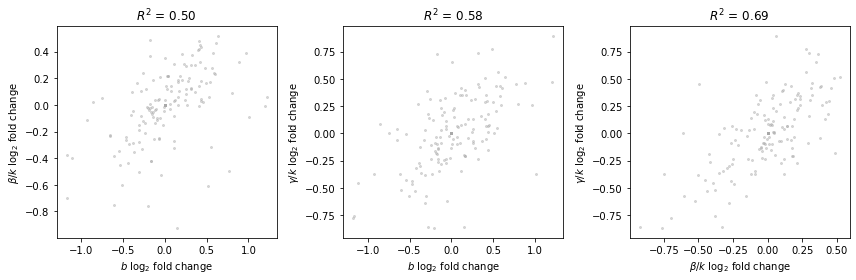

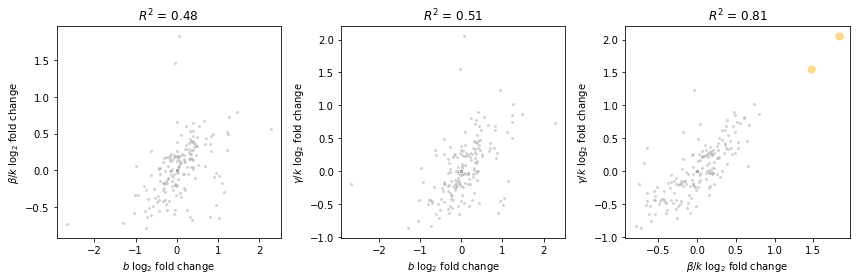

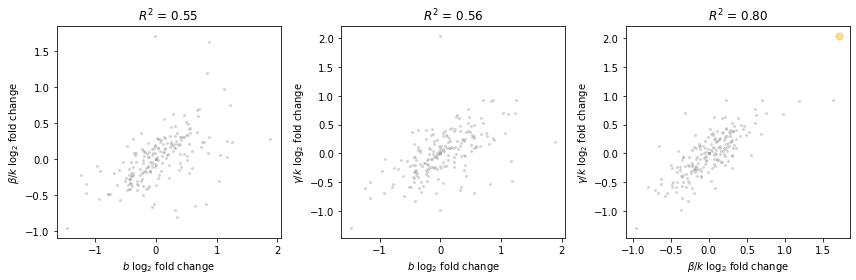

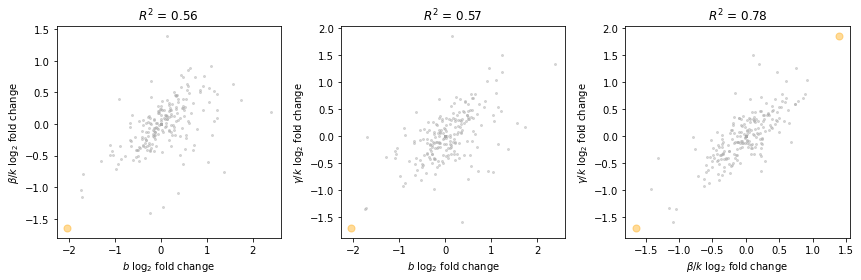

In [35]:
pairs = [[0,1],[0,2],[1,2]]
q=0

raw_param_names = (r'$b$',r'$\beta/k$',r'$\gamma/k$')

for j in range(n_datasets):
    fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
    q=0
    for pair in pairs:
        k1 = pair[0]
        k2 = pair[1]
        gf = dr_par[j,:,k1] & dr_par[j,:,k2]

        x = fc_par[j,:,k1]
        y = fc_par[j,:,k2]
        x[np.isnan(x)] = 0 
        y[np.isnan(y)] = 0

        ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
        ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
        ax1[q].set_xlabel(raw_param_names[k1]+' $\log_2$ fold change')
        ax1[q].set_ylabel(raw_param_names[k2]+' $\log_2$ fold change')
        xl = [x.min(),y.max()]
        cc = np.corrcoef(x,y)[0,1]
        ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
        q+=1
    fig1.tight_layout()

## DE-$\mu$ testing with biological replicates

Obtain $\log_2$ mean expression values across the four datasets for each cell type

In [36]:
par_vals_uncorrected = np.zeros((2,n_datasets,n_genes,n_phys_pars))
mean_vals = np.zeros((2,n_datasets,n_genes))
sigma_vals = np.zeros((2,n_datasets,n_genes,n_phys_pars))
for j in range(n_datasets):
    par_vals_uncorrected[0,j,:,:] = sr_arr_gaba[j].phys_optimum
    par_vals_uncorrected[1,j,:,:] = sr_arr_glu[j].phys_optimum
    mean_vals[0,j,:] = np.log2([x['S_mean'] for x in sd_arr_gaba[j].moments])
    mean_vals[1,j,:] = np.log2([x['S_mean'] for x in sd_arr_glu[j].moments])
    sigma_vals[0,j,:,:] = sr_arr_gaba[j].sigma
    sigma_vals[1,j,:,:] = sr_arr_glu[j].sigma


Then, run a $t$-test on those values.

Text(0, 0.5, 'Average Glu $\\log_2$ $\\mu_M$')

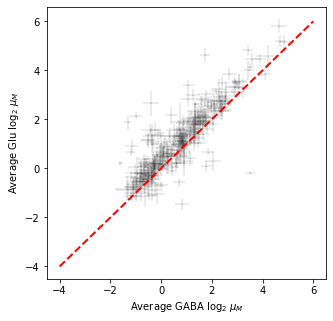

In [37]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))
ax1.errorbar(mean_vals[0,:,:].mean(0),mean_vals[1,:,:].mean(0),
                 mean_vals[0,:,:].std(0),mean_vals[1,:,:].std(0),'k.',alpha=0.1,markersize=1)

xl = [-4,6]
plt.plot(xl,xl,'r--',linewidth=2)
plt.xlabel('Average GABA $\log_2$ $\mu_M$')
plt.ylabel('Average Glu $\log_2$ $\mu_M$')

In [40]:
p_mean = np.zeros(n_genes)
for i in range(n_genes):
    p_mean[i] = scipy.stats.ttest_ind(mean_vals[0,:,i],mean_vals[1,:,i],equal_var=False)[1]

We only have four data points, so the $t$-test does not have much power; we only find four genes we can confidently say are DE.

Text(0.5, 0, 'Average $\\mu_M$ fold change across 4 datasets')

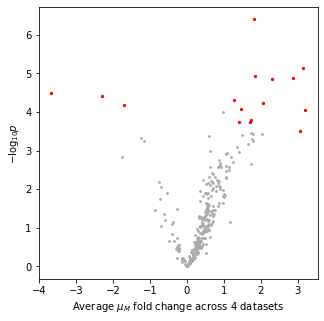

In [41]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

fc_mean = (mean_vals[1,:,:]-mean_vals[0,:,:]).mean(0)
gf_pval = p_mean<pval_thr

gf_fc = np.abs(fc_mean)>1

de_ttest_multi = gf_pval & gf_fc

logp_mean = -np.log10(p_mean)
ax1.scatter(fc_mean[de_ttest_multi],logp_mean[de_ttest_multi],color='r',s=5)
ax1.scatter(fc_mean[~de_ttest_multi],logp_mean[~de_ttest_multi],color='darkgray',s=3)
ax1.set_ylabel(r'$-\log_{10} p$')
ax1.set_xlabel(r'Average $\mu_M$ fold change across 4 datasets')


## DE-$\theta$ testing with biological replicates

Inspect the fit parameter values. We observe offsets and hypothesize these are due to imprecision in the sampling parameter fits.

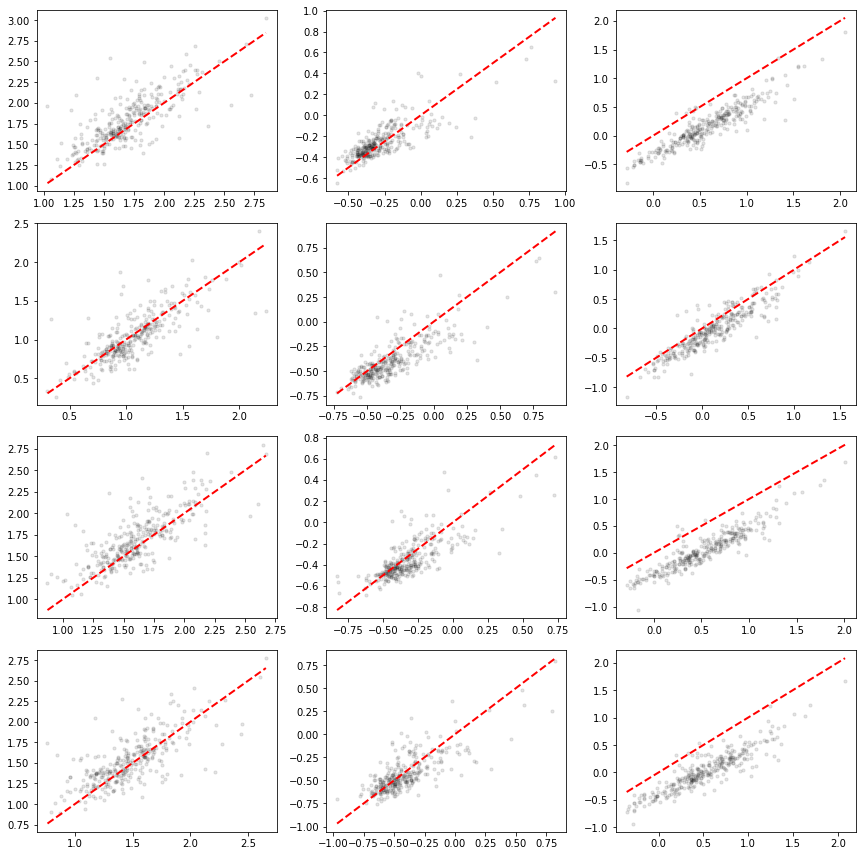

In [42]:
fig1,ax1 = plt.subplots(n_datasets,n_phys_pars,figsize=(12,12))
for d in range(n_datasets):
    for k in range(n_phys_pars):
        x=par_vals_uncorrected[0,d,:,k]
        y=par_vals_uncorrected[1,d,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [44]:
offsets = []
par_vals = np.copy(par_vals_uncorrected)
for k in range(n_phys_pars):
    m1 = par_vals_uncorrected[0,0,:,k]
    for j in range(1,n_datasets):
        m2 = par_vals_uncorrected[0,j,:,k]
        offset = monod.analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[0,j,:,k] -= offset
    for j in range(n_datasets):
        m2 = par_vals_uncorrected[1,j,:,k]
        offset = monod.analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[1,j,:,k] -= offset

Inspect the fit parameter values after correction.

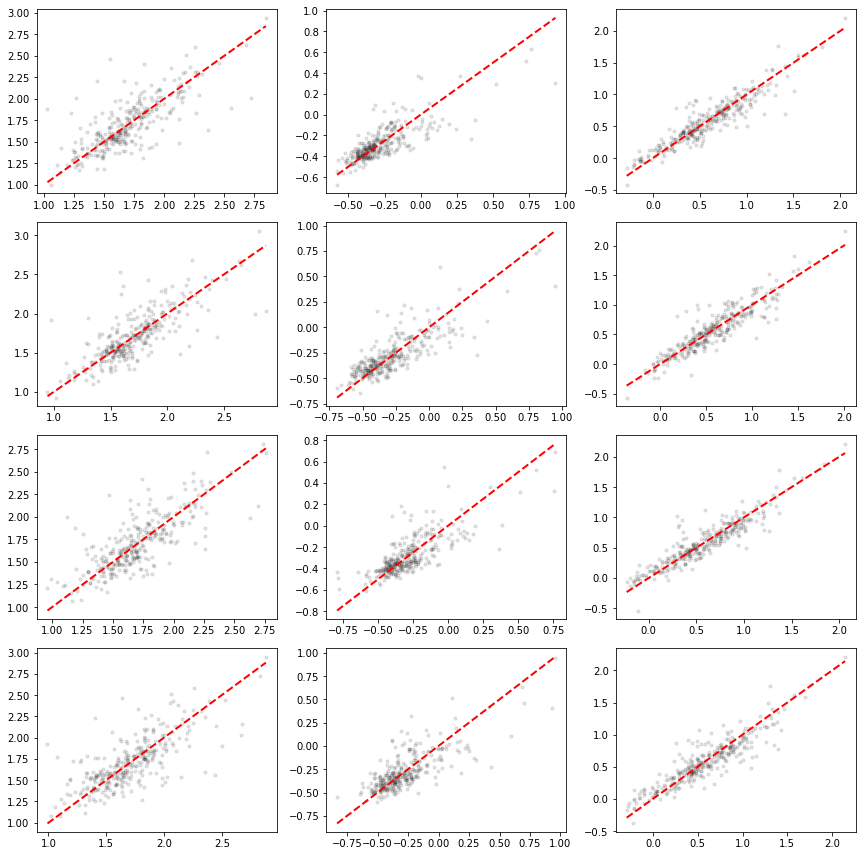

In [45]:
fig1,ax1 = plt.subplots(n_datasets,n_phys_pars,figsize=(12,12))
for d in range(n_datasets):
    for k in range(n_phys_pars):
        x=par_vals[0,d,:,k]
        y=par_vals[1,d,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

Plot average and standard deviation across four datasets.

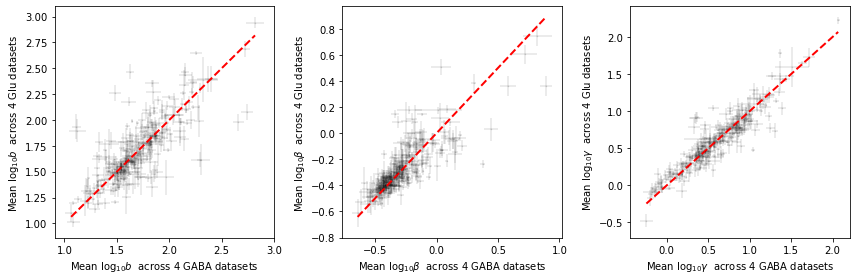

In [46]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
p =  []
for k in range(n_phys_pars):
    x=par_vals[0,:,:,k].mean(0)
    y=par_vals[1,:,:,k].mean(0)
    xl = [min(x),max(x)]
    ax1[k].errorbar(x,y,
                     par_vals[0,:,:,k].std(0),par_vals[1,:,:,k].std(0),'k.',alpha=0.1,markersize=1) 
    
    ax1[k].plot(xl,xl,'r--',linewidth=2)
    ax1[k].set_xlabel(r'Mean '+param_names[k]+'  across 4 GABA datasets')
    ax1[k].set_ylabel(r'Mean '+param_names[k]+'  across 4 Glu datasets')
fig1.tight_layout()

In [47]:
p_par = np.zeros((n_genes,n_phys_pars))
for k in range(n_phys_pars):
    for j in range(n_genes):
        p_par[j,k] = scipy.stats.ttest_ind(par_vals[0,:,j,k],par_vals[1,:,j,k],equal_var=False)[1]
    

Use an analogous $t$-test to identify DE-$\theta$ genes, then plot against mean fold change in the parameter value.

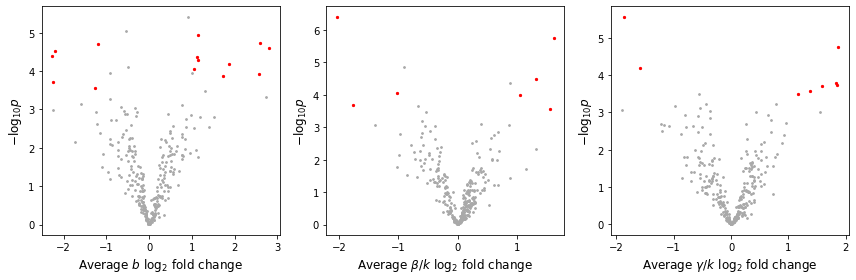

In [48]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
fc_par_multi = ((par_vals[1,:,:,:]-par_vals[0,:,:,:])/np.log10(2)).mean(0)
dr_par_multi = np.zeros((n_genes,n_phys_pars),dtype=bool)
for k in range(n_phys_pars):
    fc_d = fc_par_multi[:,k]
    gf_pval = p_par[:,k]<pval_thr
    
    gf_fc = np.abs(fc_d)>1
    gf = gf_pval & gf_fc
    
    dr_par_multi[:,k] = gf
    
    logp_par = -np.log10(p_par[:,k])
    ax1[k].scatter(fc_d[gf],logp_par[gf],color='r',s=5)
    ax1[k].scatter(fc_d[~gf],logp_par[~gf],color='darkgray',s=3)
    ax1[k].set_ylabel(r'$-\log_{10} p$',fontsize=fs)
    ax1[k].set_xlabel('Average ' + raw_param_names[k]+' $\log_2$ fold change',fontsize=fs)
fig1.tight_layout()


fig_string = sr_arr_gaba[0].batch_analysis_string+'/volcano_validation.png'
plt.savefig(fig_string,dpi=450)


We see similar patterns of co-regulation.

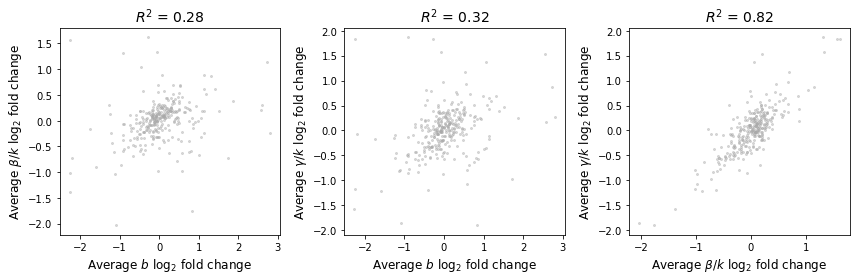

In [49]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[0,1],[0,2],[1,2]]
q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
    gf = np.zeros(n_genes,dtype=bool)
#     gf = dr_par_multi[:,k1] & dr_par_multi[:,k2]
    
    x = fc_par_multi[:,k1]
    y = fc_par_multi[:,k2]
    
    ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel('Average ' +raw_param_names[k1]+' $\log_2$ fold change',fontsize=fs)
    ax1[q].set_ylabel('Average ' +raw_param_names[k2]+' $\log_2$ fold change',fontsize=fs)
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc),fontsize=14)
    q+=1
fig1.tight_layout()


fig_string = sr_arr_gaba[0].batch_analysis_string+'/param_correlations.png'
plt.savefig(fig_string,dpi=450)


## Validation comparisons

First, we define categories for analysis. These are: 
* Modulation in $b$, $\beta$, $\gamma$, $k$
* Modulation in $\mu$
* Cases where $\mu$ intersects with modulation in at least one of the parameters
* Cases where $\neg \mu$ intersects with modulation in any of the parameters

We start by defining the $k$ modulation cases.

In [50]:
dr_par_full = np.concatenate((dr_par,(dr_par[:,:,1] & dr_par[:,:,2])[:,:,None]),2)
fc_kpar = ((fc_par[:,:,1]+fc_par[:,:,2])/2)
fc_par_full = np.concatenate((fc_par,fc_kpar[:,:,None]),2)

In [51]:
dr_par_multi_full = np.concatenate((dr_par_multi,(dr_par_multi[:,1] & dr_par_multi[:,2])[:,None]),1)
fc_kpar_multi = ((fc_par_multi[:,1]+fc_par_multi[:,2])/2)
fc_par_multi_full = np.concatenate((fc_par_multi,fc_kpar_multi[:,None]),1)

### Single-dataset case

Parameter modulation.

First output: Rows are datasets, columns are parameters.
Second output: union.
Third output: intersection.

In [52]:
print(dr_par_full.sum(1))
print(dr_par_full.any(0).sum(0))
print(dr_par_full.all(0).sum(0))

[[0 0 0 0]
 [2 2 2 2]
 [1 3 2 1]
 [2 4 4 2]]
[4 7 6 3]
[0 0 0 0]


 Mean modulation; same conventions.

In [53]:
print(de_ttest.sum(1)[:,None])
print(de_ttest.any(0).sum())
print(de_ttest.all(0).sum())

[[19]
 [13]
 [26]
 [23]]
28
13


Mean and parameter modulation. About 40-60% of the genes identified by $t$-test are also identified by the FPI $Z$-test.

In [54]:
print(((dr_par_full.any(2) & de_ttest).sum(1))[:,None])

[[0]
 [1]
 [2]
 [1]]


Parameter modulation not accompanied by mean modulation identiable by $t$-test. This appears to be the predominant mode. 

In [55]:
print(((dr_par_full & (~de_ttest)[:,:,None]).sum(1)))

[[0 0 0 0]
 [2 1 1 1]
 [0 2 1 0]
 [2 3 4 2]]


### Multi-dataset case

Parameter modulation.

In [56]:
print(dr_par_multi_full.sum(0))

[14  7  8  4]


Mean modulation.

In [57]:
print(de_ttest_multi.sum())

16


Mean and parameter modulation. The means identified as distinct do not have sufficiently large discrepancies in distributions.

In [58]:
print(((dr_par_multi_full.any(1) & de_ttest_multi).sum()))

7


Parameter modulation not accompanied by mean modulation identiable by $t$-test. Again, this overwhelmingly predominates.

In [59]:
print(((dr_par_multi_full & (~de_ttest_multi)[:,None]).sum(0)))

[11  4  5  2]


### Fixed-point iteration / validation comparison

Genes that appear as DE-$\theta$ in any or all of the single-dataset results, as well as in validation.

In [60]:
print((dr_par_full.any(0) & dr_par_multi_full).sum(0))
print((dr_par_full.all(0) & dr_par_multi_full).sum(0))

[4 2 4 2]
[0 0 0 0]


Genes identified as DE, analogously. This is less robust.

In [61]:
print((de_ttest.any(0) & de_ttest_multi).sum(0))
print((de_ttest.all(0) & de_ttest_multi).sum(0))

12
10


Genes identified as DE-$\theta$ but not DE-$\mu$. This is a large fraction of them.

In [62]:
print(((dr_par_full & ~de_ttest[:,:,None]).any(0) & dr_par_multi_full & ~de_ttest_multi[:,None]).sum(0))
print(((dr_par_full & ~de_ttest[:,:,None]).all(0) & dr_par_multi_full & ~de_ttest_multi[:,None]).sum(0))

[4 1 3 1]
[0 0 0 0]


Let us consider the genes identified as DE-$\theta$ in validation and at least one of the single-dataset cases, but nowhere identified as DE-$\mu$.

In [63]:
gf_drnotde = ((dr_par_full & ~de_ttest[:,:,None]).any(0) & dr_par_multi_full & ~de_ttest_multi[:,None])

### Gene identities

In [64]:
param_names_text = ('log10 b','log10 beta','log10 gamma','log10 k')

for k in range(n_phys_pars+1):
    print('Parameter: '+param_names_text[k])
    print(gn[gf_drnotde[:,k]])

Parameter: log10 b
['Grm1' 'Trhde' 'Ptk2' 'Prkag2']
Parameter: log10 beta
['Grb10']
Parameter: log10 gamma
['Trhde' 'Grb10' 'Nptn']
Parameter: log10 k
['Grb10']


Now, let us consider the genes with less than twofold modulation according to $t$-test performed in validation.

In [65]:
gf_fc = np.abs(fc_mean)<1
gf = gf_drnotde & gf_fc[:,None]

In [66]:
for k in range(n_phys_pars+1):
    print('Parameter: '+param_names_text[k])
    print(gn[gf[:,k]])

Parameter: log10 b
['Trhde']
Parameter: log10 beta
[]
Parameter: log10 gamma
['Trhde' 'Nptn']
Parameter: log10 k
[]


Finally, let's look at the fits.

In [67]:
gf = np.logical_or(gf[:,0], gf[:,3])

In [68]:
j=2

In [69]:
from matplotlib.ticker import AutoLocator

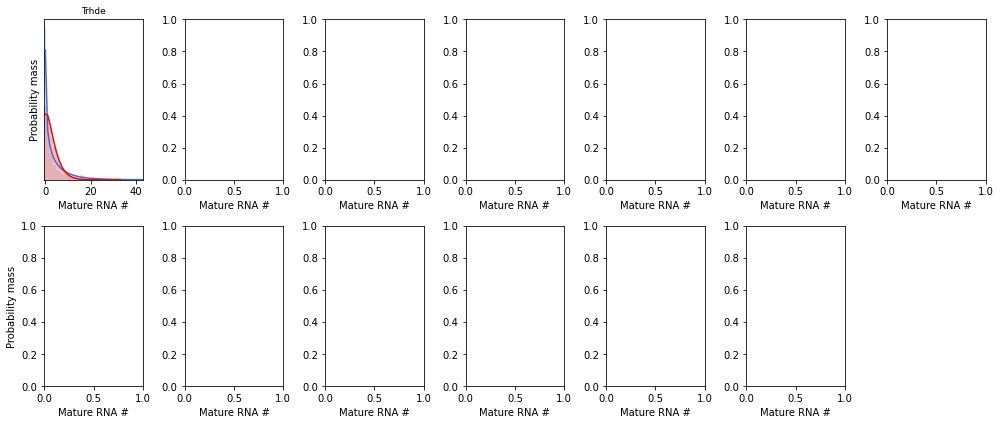

In [71]:
monod.analysis.compare_gene_distributions([sr_arr_gaba[j],sr_arr_glu[j]],[sd_arr_gaba[j],sd_arr_glu[j]],sz = (2,7),figsize = (14,6),\
               marg='mature',logscale=None,title=True,\
               genes_to_plot = gf)
fig1 = plt.gcf()
fig1.delaxes(plt.gca())
i=0
for ax in fig1.axes:
    ax.xaxis.set_major_locator(AutoLocator()) 
    ax.set_xlabel('Mature RNA #')
    if i==0 or i==7:
        ax.set_ylabel('Probability mass')
    i+=1
fig1.tight_layout()
fig_string = sr_arr_gaba[0].batch_analysis_string+'/matdist.png'
plt.savefig(fig_string,dpi=450)


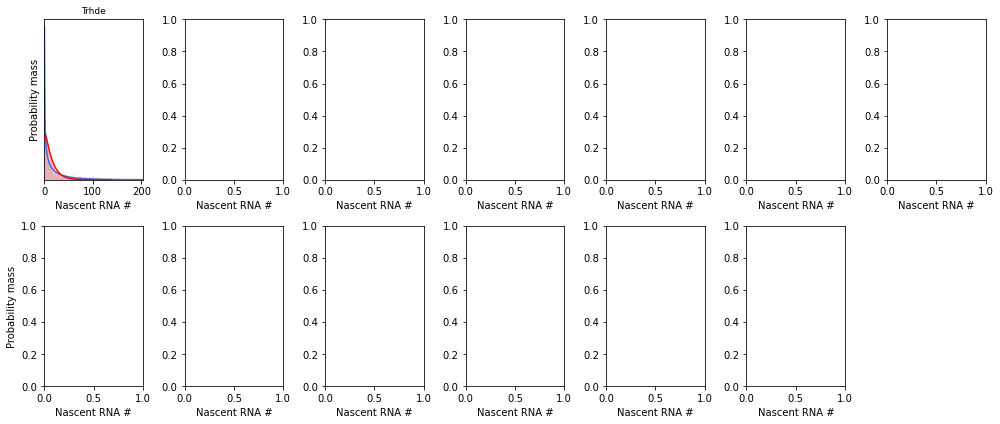

In [72]:
monod.analysis.compare_gene_distributions([sr_arr_gaba[j],sr_arr_glu[j]],[sd_arr_gaba[j],sd_arr_glu[j]],sz = (2,7),figsize = (14,6),\
               marg='nascent',logscale=None,title=True,\
               genes_to_plot = gf)
fig1 = plt.gcf()
fig1.delaxes(plt.gca())
i=0
for ax in fig1.axes:
    ax.xaxis.set_major_locator(AutoLocator()) 
    ax.set_xlabel('Nascent RNA #')
    if i==0 or i==7:
        ax.set_ylabel('Probability mass')
    i+=1
fig1.tight_layout()
fig_string = sr_arr_gaba[0].batch_analysis_string+'/nasdist.png'
plt.savefig(fig_string,dpi=450)


Several genes are conspicuously bimodal, but have not been rejected by the chi-squared procedure. This is possibly due to internal heterogeneity, particularly in the GABAergic class (blue).

In [73]:
t2 = time.time()
print('Runtime: {:.2f} seconds.'.format(t2-t1))

Runtime: 411.31 seconds.
